In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning) # Ignore User Warning regarding Shapely

import matplotlib.pyplot as plt
import contextily
import pandas as pd
import geopandas as gpd
import pymssql
from shapely import wkb
from tobler.area_weighted import area_interpolate
import os

# Rasterio Installation bug where the Environment variable 'PROJ_LIB' isn't looking in the right file for 'Proj.db' SQLlite Database
# After installation of contextily (and by extension rasterio), you need to find the folder where rasterio is storing the 'Proj.db' file and set the environment variable 'PROJ_LIB' to use the right file path
os.environ['PROJ_LIB'] = '/Users/ahadhussain/opt/anaconda3/lib/python3.9/site-packages/rasterio/proj_data/'

In [2]:
database = 'Pushing-P-DB'
table1 = 'dbo.NJ_Cities'
table2 = 'dbo.NJ_Census_Tracts'
user = 'pushing_p'
password  = 't3stP@ssword'
server = 'gen10-data-fundamentals-22-02-sql-server.database.windows.net'


# Retrieve Training Data for Geographically Weighted Regression Model
conn = pymssql.connect(server, user, password, database)

# Query select all rows from SQL tables to insert into their respective DataFrames
query1 = f'SELECT * FROM {table1}'
query2 = f'SELECT * FROM {table2}'
df = pd.read_sql(query1, conn)
tract_info = pd.read_sql(query2, conn)

# Use a function to convert wkb_hex string in SQL database to polygonal geometries (WKB stands for Well-Known Binary, which is commonly used for encoding geographic polygons)
# WKT, well-known text, markup can also be used

def convert_to_polygon(line):
    return wkb.loads(line, hex=True)
df['geometry'] = df['geometry'].apply(convert_to_polygon)
tract_info['geometry'] = tract_info['geometry'].apply(convert_to_polygon)

# Convert from pandas to geopandas dataframes
df = gpd.GeoDataFrame(df, geometry=df['geometry'], crs = 'epsg:4269')
tract_info = gpd.GeoDataFrame(tract_info, geometry=tract_info['geometry'], crs = 'epsg:4269')

# Add % Uninsured Column
df['% Uninsured'] = df['Uninsured Population']/df['City Population']*100
tract_info['% Uninsured'] = tract_info['Uninsured Population']/tract_info['City Population']*100


In [3]:
df.head()

,State,City,County,Unemployment Rate (16 & Over),Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years",...,"NUI, Men","NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Natives","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders","NUI, Other Races",geometry,% Uninsured
0,New Jersey,South Bound Brook Borough,Somerset County,8.4,86667,4541,432,23,26,28,...,231,201,159,0,17,62,0,112,"POLYGON ((-74.54279 40.55520, -74.53715 40.558...",9.513323
1,New Jersey,Absecon,Atlantic County,9.1,69293,8352,504,43,81,29,...,300,204,269,117,0,0,0,114,"POLYGON ((-74.53138 39.42627, -74.52287 39.435...",6.034483
2,New Jersey,Ramsey Borough,Bergen County,2.3,156058,14915,259,11,11,0,...,159,100,199,4,0,4,0,52,"POLYGON ((-74.17616 41.05181, -74.17315 41.054...",1.736507
3,New Jersey,Estell Manor,Atlantic County,2.7,100938,1682,41,0,0,8,...,18,23,41,0,0,0,0,0,"POLYGON ((-74.86491 39.33847, -74.86330 39.341...",2.437574
4,New Jersey,Cherry Hill Township,Camden County,4.5,101477,70248,2103,73,224,67,...,1045,1058,1037,92,0,551,0,222,"POLYGON ((-75.06610 39.92585, -75.06162 39.930...",2.993680


In [4]:
df.shape

(559, 25)

In [5]:
tract_info.head()

,State,County,Census Tract,Unemployment Rate (16 & Over),Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years",...,"NUI, 65 years and older","NUI, Men","NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Natives","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders",geometry,% Uninsured
0,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-75.08661 39.44781, -75.08231 39.449...",NaN
1,New Jersey,Cumberland County,Census Tract 103.02,5.6,52837.0,1183.0,55.0,0.0,17.0,0.0,...,0.0,34.0,21.0,55.0,0.0,0.0,0.0,0.0,"POLYGON ((-75.24288 39.28057, -75.24005 39.282...",4.649197
2,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-74.06749 40.71857, -74.06673 40.720...",NaN
3,New Jersey,Hudson County,Census Tract 74,1.7,190975.0,4972.0,8.0,0.0,0.0,0.0,...,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-74.04147 40.71347, -74.03645 40.712...",0.160901
4,New Jersey,Mercer County,Census Tract 30.09,11.5,69052.0,5990.0,444.0,0.0,12.0,45.0,...,0.0,398.0,46.0,403.0,18.0,0.0,23.0,0.0,"POLYGON ((-74.69241 40.21257, -74.68845 40.218...",7.412354


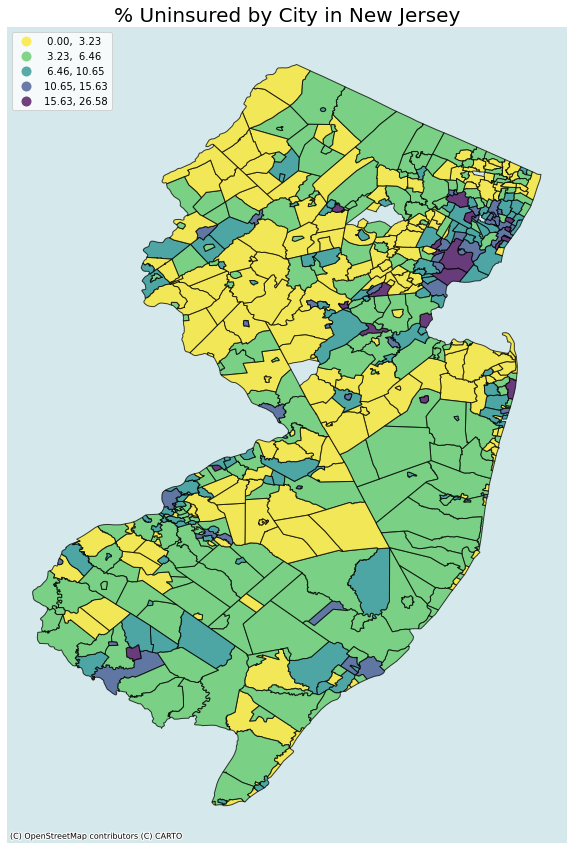

In [6]:
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(15, 15))

# Build choropleth
df.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme='natural_breaks',
    k=5, 
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Voyager,
)

plt.title('% Uninsured by City in New Jersey', fontsize=20)
ax.set_axis_off();

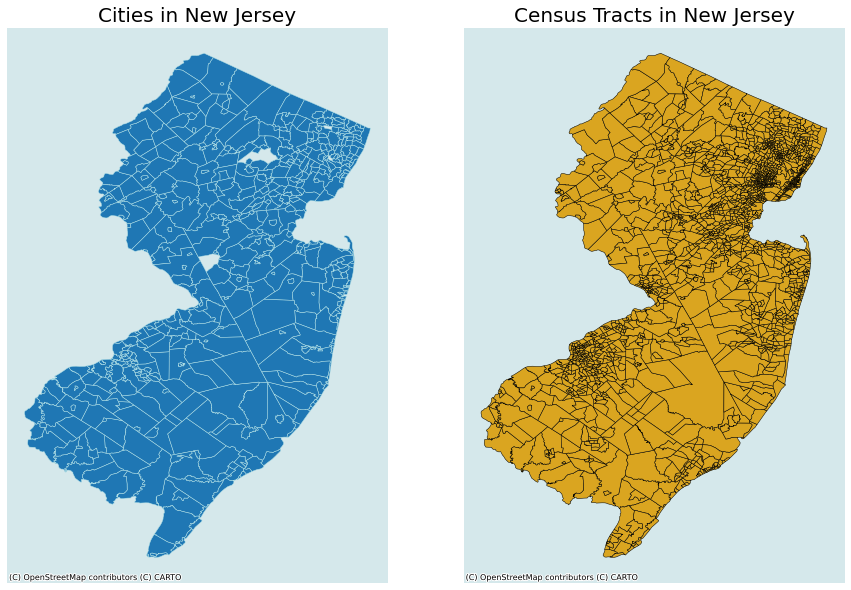

In [7]:
fig, ax = plt.subplots(1,2, figsize=(15,20))

df.plot(ax=ax[0], edgecolor = 'powderblue', linewidth = 0.5)
tract_info.plot(ax=ax[1], color = 'goldenrod',edgecolor = 'black', linewidth = 0.5)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)
ax[0].set_title('Cities in New Jersey', fontsize=20)
ax[1].set_title('Census Tracts in New Jersey', fontsize=20)
ax[0].axis('off')
ax[1].axis('off');


#### Areal Interpolation:
- Areal interpolation is the process making estimates from a source set of polygons to an overlapping but incongruent set of target polygons. 

- The simplest technique available in `tobler` is **simple areal interpolation** in which variables from the source data are weighted according to the overlap between source and target polygons, then reaggregated to fit the target polygon geometries

In [8]:
# Drop rows with null values (about 175 counties are missing healthcare information so we drop those from our analysis)
tract_info.dropna(inplace=True)
tract_info.shape

(1809, 24)

In [9]:
extensive_variables = list(df.drop(['State','County','City','geometry','Unemployment Rate (16 & Over)', '% Uninsured'], axis=1).columns)
results = area_interpolate(source_df=df, target_df=tract_info, intensive_variables = ['Unemployment Rate (16 & Over)'], extensive_variables=extensive_variables)

In [10]:
results.head()

,Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years","NUI, 26 to 34 years","NUI, 35 to 44 years","NUI, 45 to 54 years","NUI, 55 to 64 years",...,"NUI, Men","NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Natives","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders","NUI, Other Races",Unemployment Rate (16 & Over),geometry
0,52837.000000,1183.000000,55.000000,0.000000,17.000000,0.000000,17.000000,10.000000,3.000000,8.000000,...,34.000000,21.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.6,"POLYGON ((-75.24288 39.28057, -75.24005 39.282..."
1,1986.981181,6796.632831,708.039446,17.649001,47.098659,93.937392,196.010479,132.614437,108.467276,88.167026,...,393.294598,314.744847,207.707166,183.118131,9.045438,131.522746,0.000000,132.354510,5.3,"POLYGON ((-74.04147 40.71347, -74.03645 40.712..."
2,3689.872859,3930.433919,231.399421,1.723477,15.057744,31.975028,71.932474,54.561643,34.650952,20.182819,...,128.353658,103.045763,142.277535,51.795010,0.000000,8.617383,0.453546,20.500302,5.6,"POLYGON ((-74.69241 40.21257, -74.68845 40.218..."
3,46548.751152,5954.599758,313.468351,18.184628,10.391216,26.843975,132.488005,54.986852,32.472550,38.101125,...,141.580319,171.888032,288.356245,0.000000,0.000000,21.648367,0.000000,3.463739,3.6,"POLYGON ((-74.10517 40.90192, -74.08875 40.900..."
4,692.923451,2370.201752,246.915844,6.154767,16.424798,32.758952,68.355080,46.246866,37.825985,30.746643,...,137.154319,109.761526,72.434086,63.859109,3.154431,45.866159,0.000000,46.156222,5.3,"POLYGON ((-74.04266 40.71583, -74.04250 40.716..."


In [11]:
# Create Uninsurance rate columns

results['% Uninsured'] = results['Uninsured Population']/results['City Population']*100
results['% African'] = results['NUI, African American']/results['Uninsured Population']*100
tract_info['% African'] = tract_info['NUI, African American']/tract_info['Uninsured Population']*100
results['% White'] = results['NUI, White']/results['Uninsured Population']*100
tract_info['% White'] = tract_info['NUI, White']/tract_info['Uninsured Population']*100

results.shape

(1809, 24)

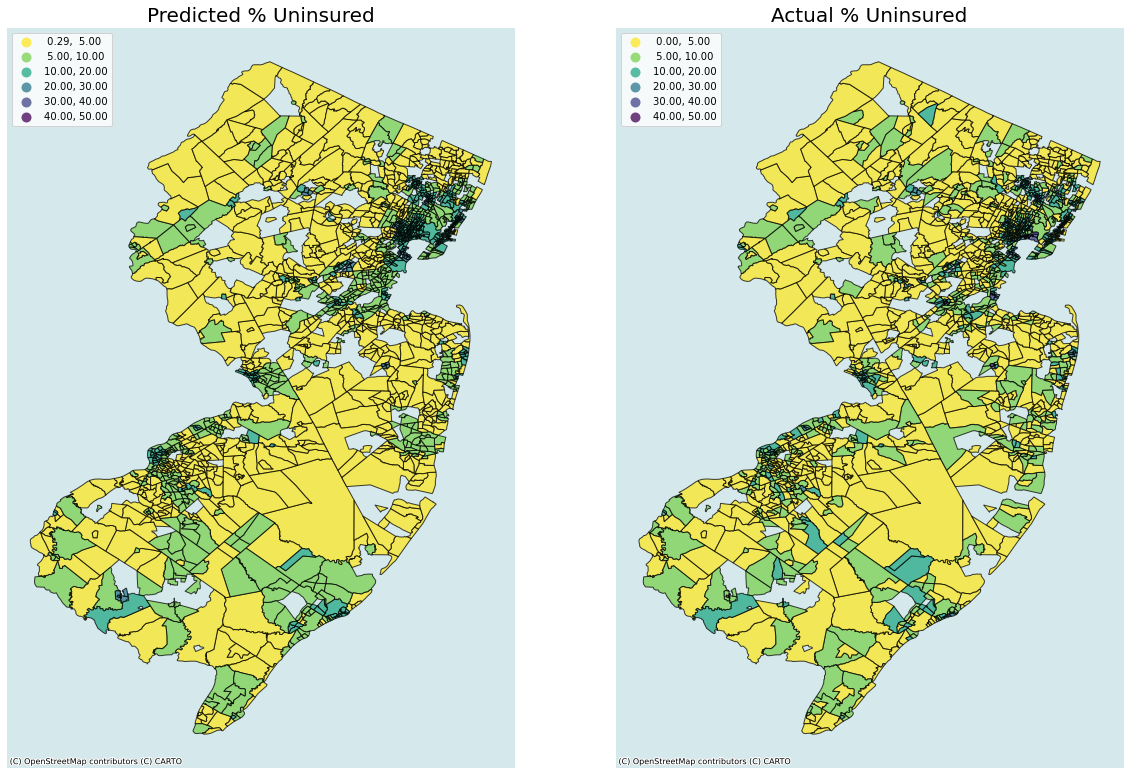

In [12]:
# Set up figure and a single axis
f, ax = plt.subplots(1,2, figsize=(20, 20))

# Build Predicted choropleth
results.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[0]
)

# Build choropleth
tract_info.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[1]
)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)

ax[0].set_title('Predicted % Uninsured',fontsize=20)
ax[1].set_title('Actual % Uninsured',fontsize=20)
ax[0].axis('off')
ax[1].axis('off');

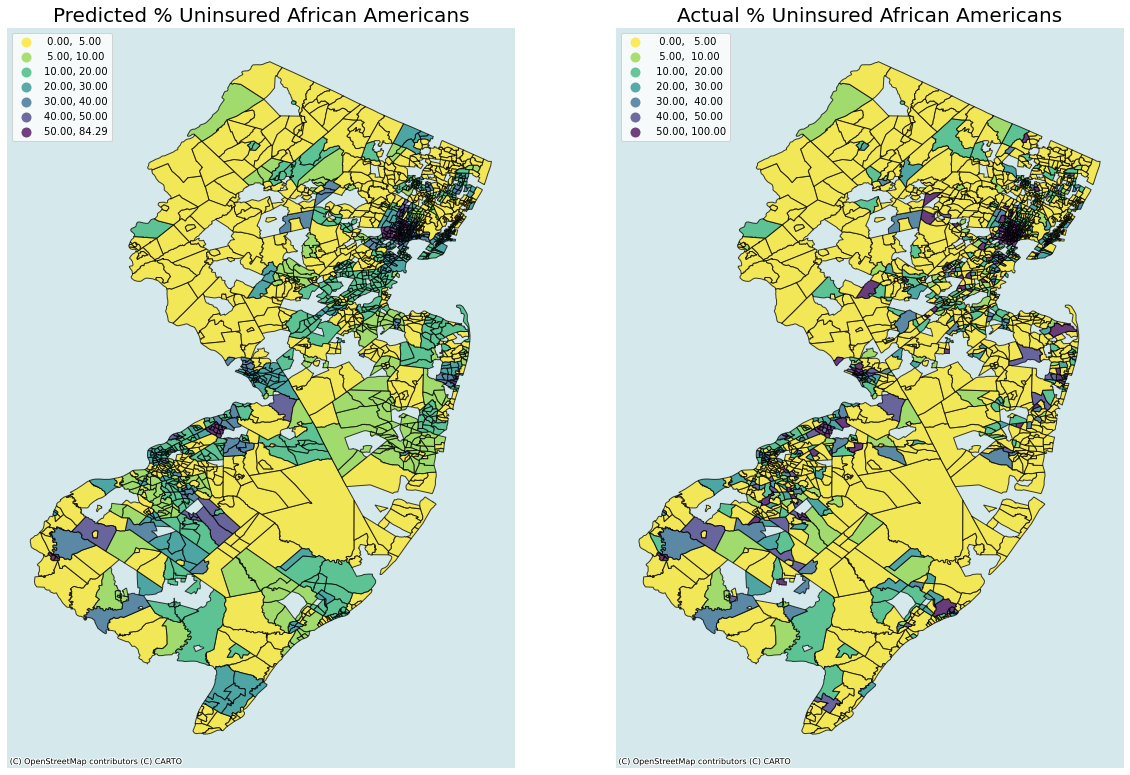

In [13]:
# Set up figure and a single axis
f, ax = plt.subplots(1,2, figsize=(20, 20))

# Build Predicted choropleth
results.plot(
    column='% African', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[0]
)

# Build choropleth
tract_info.plot(
    column='% African', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[1]
)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)

ax[0].set_title('Predicted % Uninsured African Americans',fontsize=20)
ax[1].set_title('Actual % Uninsured African Americans',fontsize=20)
ax[0].axis('off')
ax[1].axis('off');

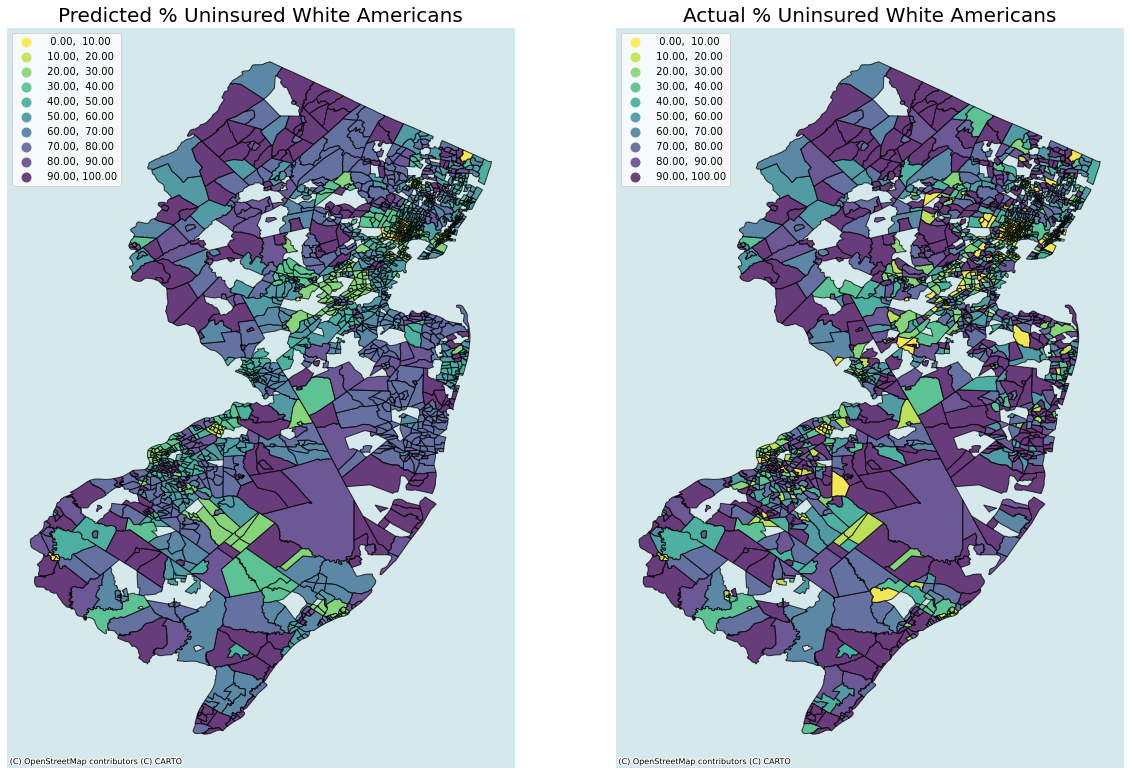

In [14]:
# Set up figure and a single axis
f, ax = plt.subplots(1,2, figsize=(20, 20))

# Build Predicted choropleth
results.plot(
    column='% White', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[10,20,30,40,50,60,70,80,90,100]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[0]
)

# Build choropleth
tract_info.plot(
    column='% White', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[10,20,30,40,50,60,70,80,90,100]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[1]
)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)

ax[0].set_title('Predicted % Uninsured White Americans',fontsize=20)
ax[1].set_title('Actual % Uninsured White Americans',fontsize=20)
ax[0].axis('off')
ax[1].axis('off');

In [15]:
# Export Model using joblib

from joblib import dump
dump(results, 'areal interpolation joblib.model')

['areal interpolation joblib.model']